In [231]:
import numpy as np
import pandas as pd

from sklearn import metrics
from scipy.stats import pearsonr, chi2_contingency
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%matplotlib inline

## 2. Preprocesing B
### 2.1 Reinspect Data

In [232]:
data = pd.read_csv('../app/data/wrangled_data.csv')
# 2.2.1 Inspect Table
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   company     1515 non-null   object 
 1   rating      1515 non-null   float64
 2   job_title   1515 non-null   object 
 3   text        1515 non-null   object 
 4   salary      1129 non-null   float64
 5   dateposted  1515 non-null   object 
 6   state       1515 non-null   object 
 7   city        1515 non-null   object 
dtypes: float64(2), object(6)
memory usage: 12.3 MB


,company,rating,job_title,text,salary,dateposted,state,city
0,online technical services,3.7,data scientist - marketing,"job descriptiondata scientist, marketingsan di...",148000.0,2022-04-13,remote,remote
1,west cap,3.5,"data scientist, botguard",human was founded in 2012 in a brooklyn sci-fi...,129000.0,2022-04-13,ny,remote in new york
2,maya ai inc.,0.0,data scientist,our maya team is expanding and we are looking ...,131000.0,2022-04-13,remote,remote
3,"emergetech, inc",0.0,data scientist,description:job categorydata scienceabout emer...,107000.0,2022-04-13,remote,remote
4,recurrent,0.0,data scientist,what's the opportunity?recurrent is on a missi...,135000.0,2022-04-13,wa,remote in seattle


From the info table I can see that the only missing values are for the Salary target feature.However, for duplicates it would 'seem' that almost all of my data is duplicated.\
It appears this way because an absolutely distinguishing feature has been removed, the url. That's what these duplicates are, individual records for multiple openings (records/observations,singular data). How this affects NLP and ML will be part of the ongoing discovery process.

In [233]:
print(data.company.unique()[:10])

['online technical services' 'west cap' 'maya ai inc.' 'emergetech, inc'
 'recurrent' 'fractal.ai' 'techtrueup' 'eab' 'ford motor company' 'redfin']


In [234]:
data.describe(include='all')

,company,rating,job_title,text,salary,dateposted,state,city
count,1515,1515.000000,1515,1515,1129.000000,1515,1515,1515
unique,97,NaN,88,173,NaN,7,30,51
top,sparkcognition,NaN,data scientist,we are currently seeking a senior data scienti...,NaN,2022-04-16,remote,remote
freq,80,NaN,348,68,NaN,381,386,386
mean,NaN,2.521980,NaN,NaN,127871.567759,NaN,NaN,NaN
std,NaN,1.779933,NaN,NaN,34714.544866,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,54000.000000,NaN,NaN,NaN
25%,NaN,0.000000,NaN,NaN,104000.000000,NaN,NaN,NaN
50%,NaN,3.500000,NaN,NaN,130000.000000,NaN,NaN,NaN
75%,NaN,3.900000,NaN,NaN,148000.000000,NaN,NaN,NaN


In [235]:
(114 + 144)/2

129.0

### 2.2 Univariate Feature Analysis & Centering
I'm going to employ visual and statistical methods to analyze each feature, starting with the target, and outside of scaling, prepare them for logistic regression which will require that each feature's vaues are normally distributes.


### 2.2a Target

In [236]:
col = 'salary'
eda_data = data[data[col]>1]

### Detecting Outliers: Using both the Z-Score and IQR methods
Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

To explore the possibility of outliers I'll start with a box and whisker plot. Those whisters reach 1.5 times past the IQR boundary on either side, and are generally provide a good means of identifying outliers - values beyond the boundaries.

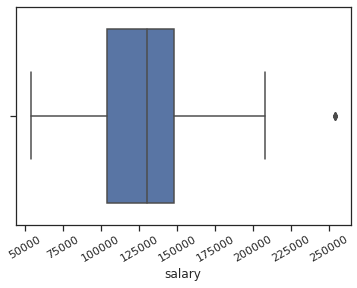

In [237]:
sns.boxplot(data=eda_data, x='salary')
plt.xticks(rotation=30)
plt.show()

To observe the impact this has on the target's shape I'll employ a KDE plot.

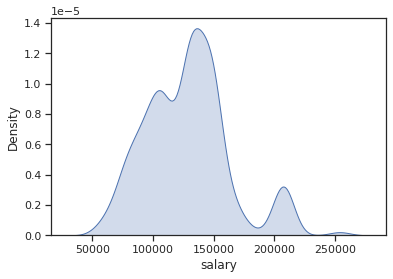

In [238]:
sns.kdeplot(eda_data.salary, shade=True)
plt.show()

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.\
Here we can see that there are five records with salary values outside the Z-score threshold.

In [239]:
outliers = []
def z_detect(data):
    sample = data[data['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(data)

[254000.0, 254000.0, 254000.0, 254000.0, 254000.0]

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.\
Here, I clearly demarcate the quartiles as well as the uppet and lower boundaries. Before removing these outliers let's take a look.

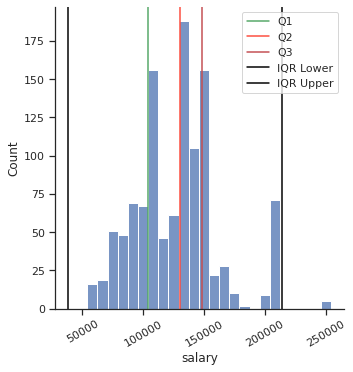

In [240]:
q1 = np.quantile(eda_data.salary, 0.25)
q2 = np.quantile(eda_data.salary, 0.5)
q3 = np.quantile(eda_data.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(eda_data.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.xticks(rotation=30)
plt.legend()
plt.show()

There aren't any outliers beyond the lower bound for either test so let's take a look at what's above the IQR threshold.\
While not guarenteed, its a good thing that both tests seem to identify the same five records, the salary values match.

In [241]:
data[data.salary > iqr_upper]

,company,rating,job_title,text,salary,dateposted,state,city
592,directv,3.7,senior director of data science,"at directv, we’re connecting the world through...",254000.0,2022-04-16,ca,remote in el segundo
682,directv,3.7,senior director of data science,"at directv, we’re connecting the world through...",254000.0,2022-04-16,ca,remote in el segundo
713,directv,3.7,senior director of data science,"at directv, we’re connecting the world through...",254000.0,2022-04-16,ca,remote in el segundo
1070,directv,3.7,senior director of data science,"at directv, we’re connecting the world through...",254000.0,2022-04-16,ca,remote in el segundo
1150,directv,3.7,senior director of data science,"at directv, we’re connecting the world through...",254000.0,2022-04-16,ca,remote in el segundo


Trimming the data, while showing the number of records were starting with and how many remain after removing the outliers viewed above.

In [242]:
print(len(data))
data1 = data[data.salary <= iqr_upper]
data2 = data[data.salary.isnull()]
data = pd.concat([data1,data2])
print(len(data))
eda_data = data[data[col]>1]

1515
1510


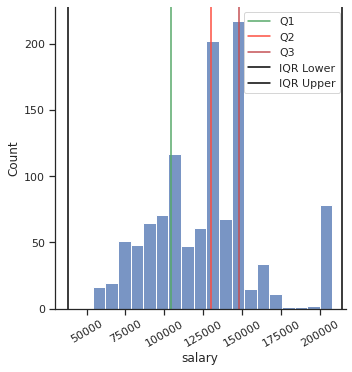

In [243]:
q1 = np.quantile(eda_data.salary, 0.25)
q2 = np.quantile(eda_data.salary, 0.5)
q3 = np.quantile(eda_data.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(eda_data.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.xticks(rotation=30)
plt.show()

Excellent, everything falls within the boundaries. While there are a number of reccords off in the high end, neither test detects them as outliers, let's check with a box and whisker plot though.

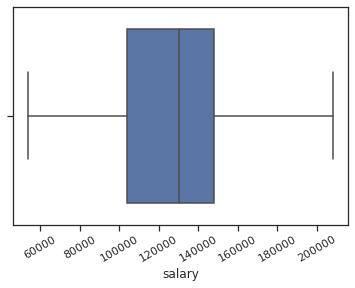

In [244]:
sns.boxplot(data=data, x='salary')
plt.xticks(rotation=30)
plt.show()

Modality might be an issue but it's something I can come back and fine tune later.

In [ ]:
#TODO check on this modality.
sns.kdeplot(eda_data.salary, shade=True)
plt.xticks(rotation=30)
plt.show()

In [ ]:
ax = sns.pairplot(data=data[data.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

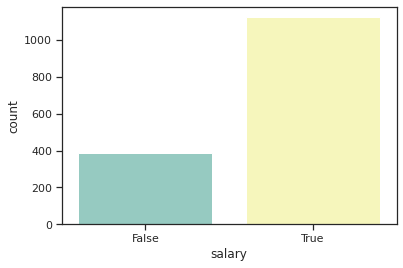

In [245]:
sns.countplot(x='salary', data=data.notnull(), palette='Set3')
plt.show()


In [246]:
null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')

74.44% of the data has salary information, should be an easy target


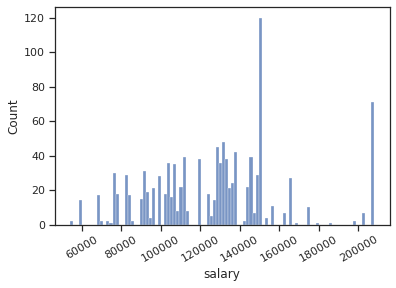

In [247]:
sns.histplot(data,x='salary',bins=100)
plt.xticks(rotation=30)
plt.show()

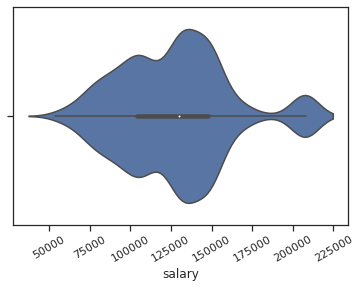

In [248]:
sns.violinplot(x="salary", data=data)
plt.xticks(rotation=30)
plt.show()

In [249]:
def Q(row):
    """Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """

    salary = row['salary']
    if salary < q1:
        return 1
    if (salary >= q1) & (salary < q2):
        return 2
    if (salary >= q2) & (salary < q3):
        return 3
    if salary >= q3:
        return 4
    else:
        return np.nan


data['target'] = data.apply( lambda row : Q(row), axis = 1)

A new target variable has been created and its values are nan, 1, 2, 3, and 4 - representing the unknown set, and four labels for the taget.

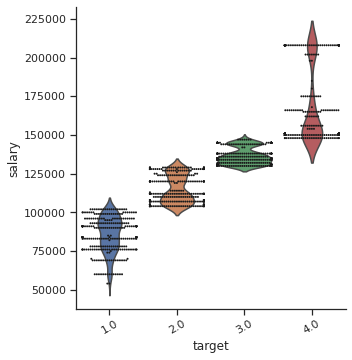

In [250]:
g = sns.catplot(x="target", y="salary", kind="violin", inner=None, data=data)
sns.swarmplot(x="target", y="salary", color="k", size=2, data=data, ax=g.ax)

plt.xticks(rotation=30)

plt.show()

<AxesSubplot:xlabel='salary'>

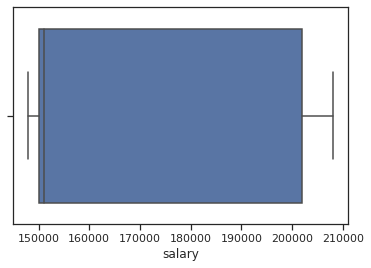

In [251]:
sns.boxplot(data=data[data.target == 4],x='salary')

And checking each target value for outliers

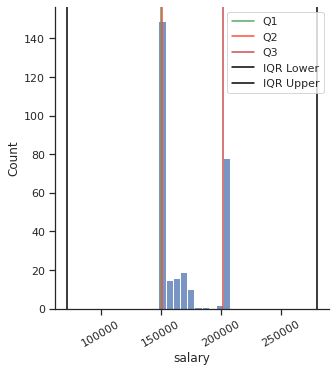

In [252]:
check = data[data.target == 4]
q1 = np.quantile(check.salary, 0.25)
q2 = np.quantile(check.salary, 0.5)
q3 = np.quantile(check.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(check.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.xticks(rotation=30)
plt.show()

'company'\
There's presently 96 different companies - that's a ton of dimensions added to the data, and I've still got to add count vectorizer. I'll try label encoding these. In the future, shifting these into clusters might be useful.\
Other than that, this variable doesn't seem to need much - 

In [253]:
data.company.value_counts()

sparkcognition     80
comcentric         69
target             59
etsy               52
ericsson           50
                   ..
ancestry            1
obxtek inc.         1
aureus group        1
pcs global tech     1
claritas llc        1
Name: company, Length: 96, dtype: int64

'rating'\
Roughly a third of the data is missing values for the company rating feature. At first I used np.fillna(0) to imput 0 for all the missing values but that sharply right-skewed the distribution towards zero.\
Then I checked is scaling the data would fix the bi-modality but I think I have two options here, drop all those records or drop a potentially valuable feature.\
For now, I'll drop the records, I can always get more, and in the future I could conduct linear regression to imput the values.

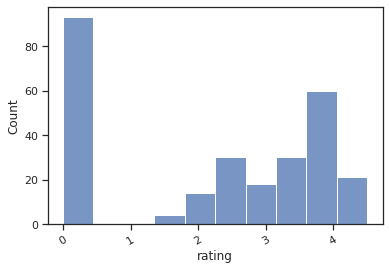

In [254]:
#TODO imput the rating with a regressor.
sns.histplot(data=data[data.target ==1], x='rating')
plt.xticks(rotation=30)
plt.show()

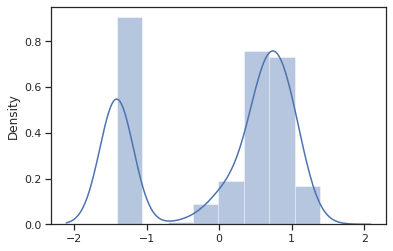

In [255]:
scale = StandardScaler()
scale = scale.fit_transform(pd.DataFrame(data['rating']))
sns.distplot(scale)
plt.show()

In [256]:
data = data[data.rating > 0]
len(data)

1030

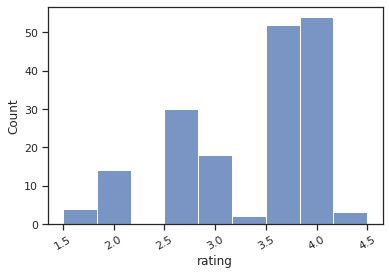

In [257]:
sns.histplot(data=data[data.target ==1], x='rating')
plt.xticks(rotation=30)
plt.show()

'job_title'\
Oddly enough, these number as many as company, I suspect multicolinearity. I'll come back to collapse these a bit and perhaps build a new feature for specializations out of these.
To be label encoded and possibly clustered later.

In [258]:
data.job_title.value_counts()

data scientist                                                149
senior data scientist                                          79
machine learning engineer                                      49
associate data scientist                                       44
senior data scientist - routing algorithm                      39
                                                             ... 
clinical trials statistician (remote)                           1
director i, data science (stp)                                  1
director of data science                                        1
data engineer - amazon distribution and grocery innovation      1
sr. principal / staff data scientist                            1
Name: job_title, Length: 69, dtype: int64

'dateposted'
This isn't going into the pipelie, despite some interesting patterns, I don't think there's enough periodic/seasonality information available here. Still, great for visualizing the job market.

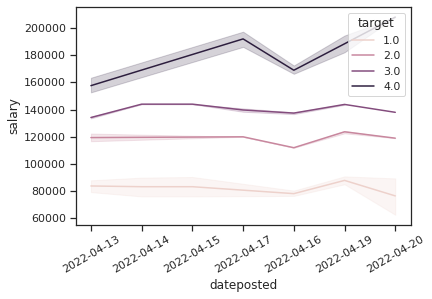

In [259]:
sns.lineplot(x="dateposted", y="salary", hue="target", data=data)
plt.xticks(rotation=30)
plt.show()

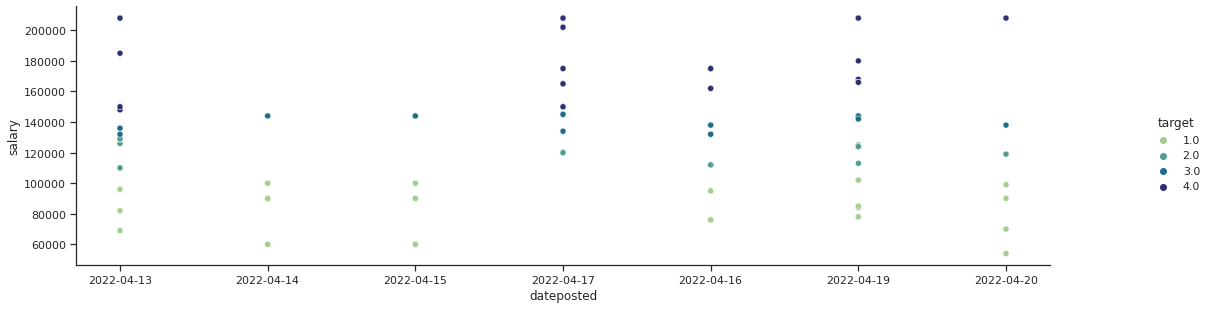

In [260]:
ax = sns.pairplot(data=data,
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="target", palette="crest")

ax.fig.set_size_inches(18,4)

In [261]:
len(data.city.value_counts())

44

In [262]:
len(data.state.value_counts())

29

## Feature Associations

In [263]:
data2 = data.drop('salary', axis=1)
data2.dropna(inplace=True)

In [264]:
target = 'target'

associated = []

for i in data2.select_dtypes('number').columns:
    if i == target:
        continue
    else:
        pearson_cor, pval = pearsonr(data2[i],data2[target])

    if pearson_cor > .3:
        associated.append([i,pearson_cor])

# Extracting column names of the dependent variables that passed the pearson correlation test of being at least .3
num_cols = []
for i in associated:
    num_cols.append(i[0])
num_cols

['rating']

As anticipated, rating passes the pearson test.

In [265]:

#TODO complete this by collecting the most significant colinear features and possibl removing them.

score_dictionary = {}
for i in data.select_dtypes('object').columns:
    feature = pd.crosstab(data[i], data[target])
    # calculate the chi squared statistic and save it as chi2, then print it:
    chi2, pval, dof, expected = chi2_contingency(feature)
    score_dictionary[i] = round(chi2,2)
score_df = pd.DataFrame(score_dictionary.items(), columns=['feature','chi2 score']).sort_values('chi2 score', ascending=False)
score_df[:-1]

,feature,chi2 score
2,text,2043.00
0,company,1757.75
1,job_title,1689.85
5,city,1302.02
4,state,972.40


Greater variance betewwen values leads to higher scores, apparently. 'text' is next.

In [266]:
data[['company','job_title','text']] = data[['company','job_title','text']].astype(str)

In [267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 0 to 1511
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   company     1030 non-null   object 
 1   rating      1030 non-null   float64
 2   job_title   1030 non-null   object 
 3   text        1030 non-null   object 
 4   salary      681 non-null    float64
 5   dateposted  1030 non-null   object 
 6   state       1030 non-null   object 
 7   city        1030 non-null   object 
 8   target      681 non-null    float64
dtypes: float64(3), object(6)
memory usage: 80.5+ KB


In [270]:
data.to_csv(f'../app/data/processed_data.csv', index=False)